# This notebook is mainly used now for checking Ryan's notebook (01d_epkm_from_annotated).
- 01e_asdf
- This compares various STAMP datasets to Fred's polysome data. We hope to see good correlation between Polysome and RiboSTAMP for RPS2 datasets, but not as strong correlation using RBFOX or Apo STAMP data. 

In [1]:
%matplotlib inline
from matplotlib_venn import venn2, venn3
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
import gffutils

In [2]:
edits_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/epkm2'

In [3]:
rps2_0_file = os.path.join(edits_dir, 'RPS2-0_S4_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated')
rps2_50_file = os.path.join(edits_dir, 'RPS2-50_S11_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated')
rps2_1000_file = os.path.join(edits_dir, 'RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated')
apo_1000_file = os.path.join(edits_dir, 'ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated')
rbfox2_1000_file = os.path.join(edits_dir, 'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated')
sample_41_file = os.path.join(edits_dir, 'Sample41_S41_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated')
sample_42_file = os.path.join(edits_dir, 'Sample42_S42_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated')
sample_13_file = os.path.join(edits_dir, 'Sample13_S31_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated')
sc_rps2_file = os.path.join(
    '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/combined_outputs_w_cov_info',
    'RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.fx.annotated'
)
sc_rps2_all_file = os.path.join(
    '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/combined_outputs_w_cov_info',
    'RPS2-STAMP_possorted_genome_bam_MD.fx.annotated'
)
# counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/for_featurecounts/counts.cds_only.txt'
# counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.cds_only.txt'
# counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.cds_and_3utr.txt'
# counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/featurecounts/counts.cds_only.txt'
counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/for_featurecounts/counts.cds_and_3utr.txt'
# counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.txt'
polysome_file = '/home/rmarina/projects/apobec/revision_riboseq_comparison/ribosome_files/Polysome_RPKM_Raw.txt'

#### ```sample_id``` is to specify which column to use for counting *read* alignments
- this needs to be the same as one of the columns in a featureCounts output. 

In [4]:
# sample_id = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bam'
# sample_id = '../Sample41_S41_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
# sample_id = '../Sample42_S42_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
# sample_id = 'results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
sample_id = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam'
# sample_id = 'results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'

# Read in annotated edit file

In [5]:
annotated_names = ['chrom','start','end','conf','cov','strand','geneid','genename','region','overlap']

edits = pd.read_csv(sc_rps2_file, sep='\t', names=annotated_names)
del edits['overlap']
edits.head()

,chrom,start,end,conf,cov,strand,geneid,genename,region
0,chr1,29990,29991,0.999980,"3,7",+,ENSG00000243485.2,MIR1302-11,noncoding_exon
1,chr1,30662,30663,0.950990,"1,6",+,ENSG00000243485.2,MIR1302-11,noncoding_exon
2,chr1,719860,719861,0.960596,"1,5",+,ENSG00000237491.4,RP11-206L10.9,noncoding_exon
3,chr1,720211,720212,0.868746,"1,15",+,ENSG00000237491.4,RP11-206L10.9,noncoding_exon
4,chr1,722356,722357,0.777821,"1,26",+,ENSG00000237491.4,RP11-206L10.9,noncoding_exon


In [6]:
# If we want to filter for conf first, this is where we do it
conf = 0.
print(edits.shape[0])
edits = edits[edits['conf'] >= conf]
print(edits.shape[0])

411598
411598


In [7]:
edits['region'].value_counts()

3utr                       242004
CDS                        142287
noncoding_exon               9696
5utr                         7566
proxintron500                4207
distintron500                3099
intergenic                   2661
miRNA                          77
proxnoncoding_intron500         1
Name: region, dtype: int64

# Filter for the regions we want to look at.

In [8]:
regions = ['CDS', '3utr']
# regions = ['CDS']
edits = edits[edits['region'].isin(regions)]
#edits = edits.loc[edits.geneid.apply(lambda x: len(x.split(','))) == 1] # removing ambiguous editing events (more than one gene)
print(edits.shape[0])

384291


# Get the number of reads that were edited (C>T conversion) summed across all genes

In [9]:
edits['edited_reads'] = edits['cov'].apply(lambda x: int(x.split(',')[0]))
edits = pd.DataFrame(edits.groupby('geneid')['edited_reads'].sum())
edits.head()

,edited_reads
geneid,
ENSG00000000003.10,592
ENSG00000000419.8,372
ENSG00000000457.9,4
ENSG00000000460.12,43
ENSG00000001036.9,240


# Read in read counts file

In [10]:
read_counts = pd.read_csv(counts_file, sep='\t', index_col=0, skiprows=1)
read_counts.head()

,Chr,Start,End,Strand,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-1_barcodes.tsv.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-2_barcodes.tsv.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-5_barcodes.tsv.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,...,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-5.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-6.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-7.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-8.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-9.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.1-0.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.downsampled60M.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.downsampled50M.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000186092,chr1,69091,70005,+,915,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,chr1;chr1;chr1,134901;137621;138533,135802;138529;139309,-;-;-,2588,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ENSG00000235249,chr1;chr1,367659;368598,368594;368634,+;+,973,0,0,0,0,0,...,18,24,23,17,28,22,22,0,0,0
ENSG00000185097,chr1;chr1,621059;621099,621095;622034,-;-,973,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
ENSG00000269831,chr1;chr1;chr1,738532;738788;739121,738618;738812;739137,-;-;-,129,0,0,0,0,0,...,0,1,0,1,1,1,1,0,0,0


In [11]:
# Printing the columns out just to confirm I'm using the correct read counts.
for c in read_counts.columns:
    print(c)

Chr
Start
End
Strand
Length
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-1_barcodes.tsv.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-2_barcodes.tsv.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-5_barcodes.tsv.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD.bam
/home/bay001

In [12]:
# read_counts = read_counts[['Length', sample_id]]

# Filter for genes that were expressed. 0-5 reads min? we'll do this later with a minimal TPM filter.
# read_counts = read_counts[read_counts[sample_id] > 0]
print('approx. {} genes expressed.'.format(read_counts.shape[0]))
total_mapped = read_counts[sample_id].sum()
print('total mapped reads: {}'.format(total_mapped))
read_counts.head()

approx. 20356 genes expressed.
total mapped reads: 91628865


,Chr,Start,End,Strand,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-1_barcodes.tsv.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-2_barcodes.tsv.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-5_barcodes.tsv.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,...,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-5.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-6.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-7.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-8.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.08-9.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bamdownsampled.1-0.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.downsampled60M.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.downsampled50M.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000186092,chr1,69091,70005,+,915,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,chr1;chr1;chr1,134901;137621;138533,135802;138529;139309,-;-;-,2588,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ENSG00000235249,chr1;chr1,367659;368598,368594;368634,+;+,973,0,0,0,0,0,...,18,24,23,17,28,22,22,0,0,0
ENSG00000185097,chr1;chr1,621059;621099,621095;622034,-;-,973,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
ENSG00000269831,chr1;chr1;chr1,738532;738788;739121,738618;738812;739137,-;-;-,129,0,0,0,0,0,...,0,1,0,1,1,1,1,0,0,0


# Convert to TPM and filter if necessary
- FredX2/3 is going to be already filtered, so the difference between our gene set and his will be larger. Let's also perform a cursory filter for expression just to make sure the difference is small.

In [13]:
min_tpm = 0.00000000001 # Just use anything that's expressed, we'll filter mostly based on Fred's dataset.

def counts_to_rpkm(feature_counts_table):
    counts = feature_counts_table.ix[:,5:]
    lengths = feature_counts_table['Length']
    mapped_reads = counts.sum()
    return lengths, (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table, skip_col=5):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    lengths, rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return pd.merge(lengths, tpm, how='outer', left_index=True, right_index=True)

tpm_counts = counts_to_tpm(
    counts_table=read_counts,
)
print("Before filtering for TPM value of {}: {}".format(min_tpm, tpm_counts.shape[0]))
filtered_tpm_counts = tpm_counts[tpm_counts[sample_id]>=min_tpm]
print("After filtering for TPM value of {}: {}".format(min_tpm, filtered_tpm_counts.shape[0]))
filtered_tpm_counts = filtered_tpm_counts[['Length', sample_id]]
filtered_tpm_counts.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Before filtering for TPM value of 1e-11: 20356
After filtering for TPM value of 1e-11: 15830


,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam
Geneid,,
ENSG00000187634,2564,34.569018
ENSG00000188976,2737,47.791318
ENSG00000187961,2527,6.395889
ENSG00000187583,2676,0.110315
ENSG00000187642,3061,0.043398


# join the read counts with edit sums
- by "edit sums" it's not exactly 1:1 with each read, since each read will be counted multiple times for each edit found. We are, however, using mapped reads as a scaling factor. 

In [14]:
edits.reset_index(inplace=True)
edits['Geneid'] = edits['geneid'].apply(lambda x: x.split('.')[0])  # since we used a mix of GENCODE/ENSEMBL-style annotations, we'll need to make them consistent.
edits.set_index('Geneid', inplace=True)
read_edit_counts = pd.merge(filtered_tpm_counts, edits[['edited_reads']], how='outer', left_index=True, right_index=True)
read_edit_counts.fillna(0, inplace=True)

# some genes aren't included in the counts matrix but are included in our edit annotations? odd. Maybe these genes have intronic edits that we're not counting at all?
read_edit_counts = read_edit_counts[read_edit_counts['Length']>0]
print(read_edit_counts.shape[0])
read_edit_counts.head()

16100


,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,edited_reads
Geneid,,,
ENSG00000000003,2091.0,52.320687,592.0
ENSG00000000005,1119.0,0.013191,0.0
ENSG00000000419,1150.0,75.751881,372.0
ENSG00000000457,6308.0,1.242496,4.0
ENSG00000000460,4213.0,6.505977,43.0


# calculate EPKM
- adding (ps)eudocount here to make log transformation do-able.

In [15]:
ps = 1 # min(polysome_rpkm_x3[polysome_rpkm_x3 > .0].min(axis=1).dropna())
print("(ps)eudocount value", ps)

(ps)eudocount value 1


In [16]:
# (# of Edited Counts (from SAILOR)) / ((total mapped read counts/10^6)*(Gene length/1000))

def epkm(row, total_mapped, colname):
    """
    Just like "RPKM" except we're looking at the number of edits (edit_counts).
    edit_counts = total number of edit conversions across a genic region (all exons, or 3'UTR+CDS, or CDS)
    If a read contains multiple C>T conversions, we end up counting it multiple times. Perhaps that's okay?
    """
    edit_counts = row[colname]
    return edit_counts/((total_mapped/1000000.)*(row['Length']/1000.))

# total_mapped = read_edit_counts[sample_id].sum()
print(total_mapped)
read_edit_counts['epkm'] = read_edit_counts.apply(epkm, axis=1, args=(total_mapped, 'edited_reads'))
read_edit_counts['epkm+ps'] = read_edit_counts['epkm'] + ps
read_edit_counts.head()

91628865


,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,edited_reads,epkm,epkm+ps
Geneid,,,,,
ENSG00000000003,2091.0,52.320687,592.0,3.089836,4.089836
ENSG00000000005,1119.0,0.013191,0.0,0.000000,1.000000
ENSG00000000419,1150.0,75.751881,372.0,3.530310,4.530310
ENSG00000000457,6308.0,1.242496,4.0,0.006920,1.006920
ENSG00000000460,4213.0,6.505977,43.0,0.111390,1.111390


# This section is copied from Ryan to make sure we're both making the same comparisons to the same polysome datasets.
- rpkms appear to be filtered for RPKM >=1 for input

In [17]:
ribo_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/ribosome_files/'
riboseq_gse94460 = pd.read_csv(ribo_dir+'GSE94460_RPKM.txt', sep='\t', index_col=0)
polysome_rpkm_x3 = pd.read_csv(ribo_dir+'fred_x3_polysome_RPKM.txt', sep='\t', index_col=0)
print(polysome_rpkm_x3.shape[0], riboseq_gse94460.shape[0])
polysome_rpkm_x3.head()
riboseq_gse94460.head()

11342 19826


,rep1_rpkm,rep2_rpkm,mean_rpkm,gene_name
ENSG00000000003,28.931269,28.843710,28.887490,TSPAN6
ENSG00000000005,0.000000,0.000000,0.000000,TNMD
ENSG00000000419,117.545249,114.376719,115.960984,DPM1
ENSG00000000457,1.719643,2.589047,2.154345,SCYL3
ENSG00000000460,10.130667,10.520884,10.325776,C1orf112


In [18]:
riboseq_gse94460 = riboseq_gse94460[riboseq_gse94460['mean_rpkm'] >= min_tpm]
print(riboseq_gse94460.shape[0])
riboseq_gse94460.head()

16533


,rep1_rpkm,rep2_rpkm,mean_rpkm,gene_name
ENSG00000000003,28.931269,28.843710,28.887490,TSPAN6
ENSG00000000419,117.545249,114.376719,115.960984,DPM1
ENSG00000000457,1.719643,2.589047,2.154345,SCYL3
ENSG00000000460,10.130667,10.520884,10.325776,C1orf112
ENSG00000000938,0.015210,0.000000,0.007605,FGR


In [19]:
polysome_rpkm_x3['x3_polysome+ps'] = polysome_rpkm_x3['x3_polysome'] + ps
riboseq_gse94460['mean_rpkm+ps'] = riboseq_gse94460['mean_rpkm'] + ps

# lots of genes that were edited but maybe not protein coding? Or maybe Fred's data is filtered? Check this.
- After applying a RPKM filter, the numbers are closer together. Maybe okay. 

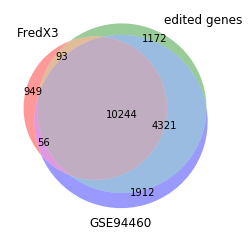

In [20]:
venn3([set(polysome_rpkm_x3.index), set(read_edit_counts.index), set(riboseq_gse94460.index)], ['FredX3', 'edited genes', 'GSE94460'])

In [21]:
print("Random 5 genes in edited list but not in PolyX: {}".format(list(set(read_edit_counts.index).difference(set(polysome_rpkm_x3.index)))[:5]))
print("Random 5 genes in PolyX but not in edited list: {}".format(list(set(polysome_rpkm_x3.index).difference(set(read_edit_counts.index)))[:5]))

Random 5 genes in edited list but not in PolyX: ['ENSG00000132330', 'ENSG00000174527', 'ENSG00000197213', 'ENSG00000168546', 'ENSG00000184845']
Random 5 genes in PolyX but not in edited list: ['ENSG00000250899', 'ENSG00000213468', 'ENSG00000262251', 'ENSG00000267161', 'ENSG00000235065']


# merge epkm and polysome and plot scatter
- use inner join because we just care about the 10k genes we can make the comparisons with.

In [22]:
read_edit_polysome = pd.merge(read_edit_counts, polysome_rpkm_x3, how='inner', left_index=True, right_index=True)
read_edit_riboseq_gse94460 = pd.merge(read_edit_counts, riboseq_gse94460, how='inner', left_index=True, right_index=True)
print(read_edit_polysome.shape[0], read_edit_riboseq_gse94460.shape[0])
read_edit_polysome.head()

10545 14835


,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,edited_reads,epkm,epkm+ps,x3_input,x3_polysome,poly/input,x3_polysome+ps
Geneid,,,,,,,,,
ENSG00000000003,2091.0,52.320687,592.0,3.089836,4.089836,32.412616,91.860482,2.834096,92.860482
ENSG00000000419,1150.0,75.751881,372.0,3.530310,4.530310,62.771277,217.714026,3.468370,218.714026
ENSG00000000457,6308.0,1.242496,4.0,0.006920,1.006920,2.335964,3.184759,1.363360,4.184759
ENSG00000000460,4213.0,6.505977,43.0,0.111390,1.111390,7.421299,14.834489,1.998907,15.834489
ENSG00000001036,3060.0,34.397040,240.0,0.855968,1.855968,38.767070,46.770120,1.206439,47.770120


In [23]:
read_edit_riboseq_gse94460.head()

,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,edited_reads,epkm,epkm+ps,rep1_rpkm,rep2_rpkm,mean_rpkm,gene_name,mean_rpkm+ps
ENSG00000000003,2091.0,52.320687,592.0,3.089836,4.089836,28.931269,28.843710,28.887490,TSPAN6,29.887490
ENSG00000000419,1150.0,75.751881,372.0,3.530310,4.530310,117.545249,114.376719,115.960984,DPM1,116.960984
ENSG00000000457,6308.0,1.242496,4.0,0.006920,1.006920,1.719643,2.589047,2.154345,SCYL3,3.154345
ENSG00000000460,4213.0,6.505977,43.0,0.111390,1.111390,10.130667,10.520884,10.325776,C1orf112,11.325776
ENSG00000000971,4129.0,0.025023,0.0,0.000000,1.000000,0.032437,0.027235,0.029836,CFH,1.029836


# log2 poly rpkm vs log2 epkm
- Hopefully there is good correlation between our "EPKM" and Fred's X3 PolyA RNA RPKM.

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


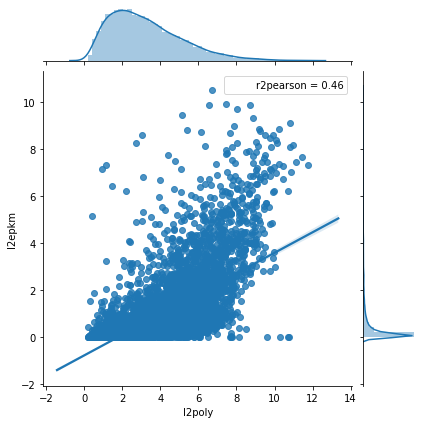

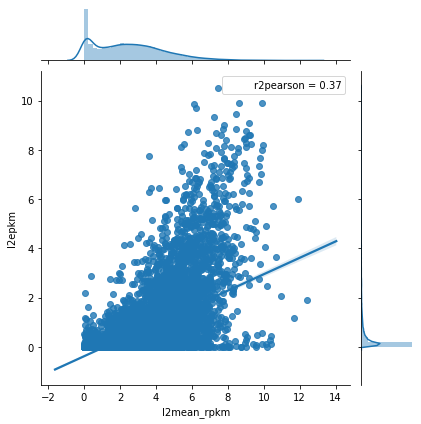

In [24]:
read_edit_polysome['l2epkm'] = np.log2(read_edit_polysome['epkm+ps'])
read_edit_polysome['l2poly/input'] = np.log2(read_edit_polysome['poly/input'])
read_edit_polysome['l2input'] = np.log2(read_edit_polysome['x3_input'])
read_edit_polysome['l2poly'] = np.log2(read_edit_polysome['x3_polysome+ps'])

read_edit_riboseq_gse94460['l2epkm'] = np.log2(read_edit_riboseq_gse94460['epkm+ps'])
read_edit_riboseq_gse94460['l2mean_rpkm'] = np.log2(read_edit_riboseq_gse94460['mean_rpkm+ps'])


def r2pearson(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2spearman(x, y):
    return stats.spearmanr(x, y)[0] ** 2



sns.jointplot(
    x='l2poly',
    y='l2epkm',
    data=read_edit_polysome,
    kind='reg',
    stat_func=r2pearson
)

sns.jointplot(
    x='l2mean_rpkm',
    y='l2epkm',
    data=read_edit_riboseq_gse94460,
    kind='reg',
    stat_func=r2pearson
)

### Also perform a correlation against the total RNA (input) to establish/see the baseline 
- there should still be correlation due to the effects of expression, but the polyA comparison should be much more correlated.

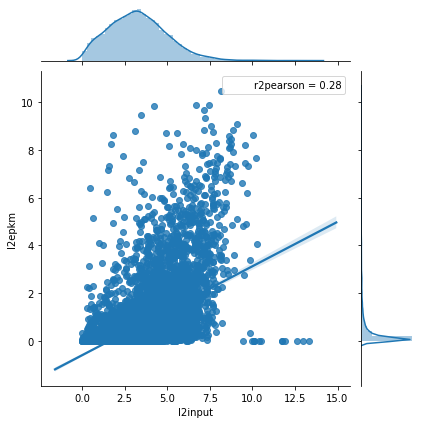

In [25]:
sns.jointplot(
    x='l2input',
    y='l2epkm',
    data=read_edit_polysome,
    kind='reg',
    stat_func=r2pearson
)


### Correlation between EPKM and the polyA/total ratio (input-normalized translation efficiency) isn't as strong. 
- We don't have an input for STAMP, so the comparison won't be apples-to-apples, so unfortunately Kris may need to word the text to exclude "translation efficiency". 
- Hopefully the decent correlation between the polyA dataset is good enough.

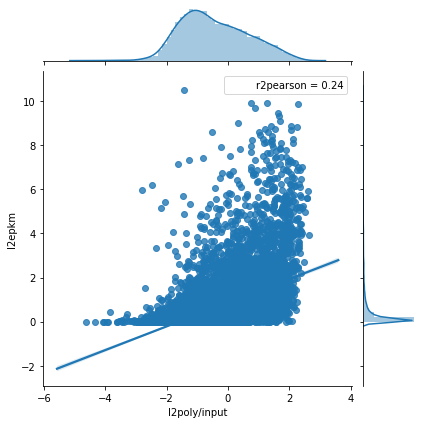

In [26]:
sns.jointplot(
    x='l2poly/input',
    y='l2epkm',
    data=read_edit_polysome,
    kind='reg',
    stat_func=r2pearson
)


# Look at some of the biggest differences in EPKM vs Polysome
- top ones seem to be MT genes? maybe we can throw out
- maybe we can see where the biggest differences are on IGV and see what makes them so different?

In [27]:
read_edit_polysome['diff'] = np.abs(read_edit_polysome['l2epkm'] - read_edit_polysome['l2poly'])
read_edit_polysome.sort_values(by='diff', ascending=False).head()

,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,edited_reads,epkm,epkm+ps,x3_input,x3_polysome,poly/input,x3_polysome+ps,l2epkm,l2poly/input,l2input,l2poly,diff
Geneid,,,,,,,,,,,,,,
ENSG00000198804,1539.0,8681.238117,0.0,0.000000,1.000000,6214.107290,1719.195095,0.276660,1720.195095,0.000000,-1.853814,12.601331,10.748356,10.748356
ENSG00000198938,784.0,33845.557098,0.0,0.000000,1.000000,10292.400710,1673.903028,0.162635,1674.903028,0.000000,-2.620292,13.329292,10.709862,10.709862
ENSG00000198727,1141.0,12181.169996,0.0,0.000000,1.000000,3921.848619,1272.413038,0.324442,1273.413038,0.000000,-1.623967,11.937318,10.314485,10.314485
ENSG00000198712,681.0,32749.271818,0.0,0.000000,1.000000,8112.521597,769.955815,0.094910,770.955815,0.000000,-3.397303,12.985935,9.590504,9.590504
ENSG00000103257,4468.0,12.378345,105.0,0.256474,1.256474,917.044182,361.535975,0.394241,362.535975,0.329381,-1.342852,9.840847,8.501980,8.172599


In [28]:
def gene_id_to_name(db):
    """
    Returns a dictionary containing a gene_id:name translation
    Note: may be different if the 'gene_id' or 'gene_name' 
    keys are not in the source GTF file
    (taken from gscripts.region_helpers)
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id.split('.')[0]] = gene.attributes['gene_name'][0]  # this is for ENSEMBL-style IDs! 
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict

def gene_id_to_protein_coding(db):
    """
    returns whether or not a gene is protein coding or not.
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id.split('.')[0]] = gene.attributes['gene_type'][0]
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict

db_file = '/projects/ps-yeolab3/bay001/annotations/hg19/gencode_v19/gencode.v19.annotation.gtf.db'
DATABASE = gffutils.FeatureDB(db_file)

gene_id_to_pc_dictionary = gene_id_to_protein_coding(DATABASE)
gene_id_to_name_dictionary = gene_id_to_name(DATABASE)
# gene_id_to_name_dictionary['ENSG00000100320.18']
print(gene_id_to_name_dictionary['ENSG00000100320'])
print(gene_id_to_pc_dictionary['ENSG00000100320'])


/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


RBFOX2
protein_coding


In [29]:
def geneid2name(row, d=gene_id_to_name_dictionary):
    try:
        return d[row['Geneid']]
    except KeyError as e:
        print(row['Geneid'])
        return 'Intergenic'
    
def geneid2pc(row, d=gene_id_to_pc_dictionary):
    try:
        return d[row['Geneid']]
    except KeyError as e:
        print(row['Geneid'])
        return 'Intergenic'
    
read_edit_polysome.reset_index(inplace=True)
read_edit_polysome['biotype'] = read_edit_polysome.apply(geneid2pc, axis=1)
read_edit_polysome['genename'] = read_edit_polysome.apply(geneid2name, axis=1)
read_edit_polysome.sort_values(by='x3_polysome', ascending=False)

,Geneid,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,edited_reads,epkm,epkm+ps,x3_input,x3_polysome,poly/input,x3_polysome+ps,l2epkm,l2poly/input,l2input,l2poly,diff,biotype,genename
3226,ENSG00000117450,890.0,2177.692439,13088.0,160.491107,161.491107,844.538307,3436.968390,4.069642,3437.968390,7.335311,2.024902,9.722019,11.747341,4.412030,protein_coding,PRDX1
5437,ENSG00000142534,759.0,2925.143677,14097.0,202.699472,203.699472,1177.172964,2823.679564,2.398696,2824.679564,7.670298,1.262250,10.201111,11.463871,3.793573,protein_coding,RPS11
5450,ENSG00000142676,1404.0,4835.698065,22669.0,176.210972,177.210972,754.801414,2227.749183,2.951437,2228.749183,7.469324,1.561418,9.559953,11.122019,3.652694,protein_coding,RPL11
339,ENSG00000034510,380.0,3494.980805,10171.0,292.110892,293.110892,769.929999,2024.880682,2.629954,2025.880682,8.195303,1.395038,9.588583,10.984333,2.789031,protein_coding,TMSB10
4847,ENSG00000136810,661.0,3615.644536,7764.0,128.189295,129.189295,351.488124,1879.137855,5.346234,1880.137855,7.013343,2.418523,8.457332,10.876623,3.863280,protein_coding,TXN
4886,ENSG00000136942,669.0,5906.747099,16860.0,275.042081,276.042081,409.137313,1780.067600,4.350783,1781.067600,8.108744,2.121275,8.676441,10.798527,2.689782,protein_coding,RPL35
4289,ENSG00000131469,531.0,6099.879359,26635.0,547.426571,548.426571,547.973361,1772.457039,3.234568,1773.457039,9.099155,1.693573,9.097962,10.792349,1.693194,protein_coding,RPL27
9931,ENSG00000198804,1539.0,8681.238117,0.0,0.000000,1.000000,6214.107290,1719.195095,0.276660,1720.195095,0.000000,-1.853814,12.601331,10.748356,10.748356,protein_coding,MT-CO1
7814,ENSG00000168653,458.0,2226.436637,3113.0,74.179062,75.179062,340.258330,1703.040852,5.005141,1704.040852,6.232259,2.323411,8.410487,10.734744,4.502485,protein_coding,NDUFS5
9985,ENSG00000198938,784.0,33845.557098,0.0,0.000000,1.000000,10292.400710,1673.903028,0.162635,1674.903028,0.000000,-2.620292,13.329292,10.709862,10.709862,protein_coding,MT-CO3


In [30]:
read_edit_polysome[['l2poly','l2epkm']].corr()

,l2poly,l2epkm
l2poly,1.000000,0.680842
l2epkm,0.680842,1.000000


# Run a quick comparison to escore metric

In [31]:
rps2_escore_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/window_outputs/RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.fx.annotated.exons.merged.txt'
rps2_escore = pd.read_csv(rps2_escore_file, sep='\t')
rps2_escore['ensembl_id'] = rps2_escore['name'].apply(lambda x: x.split('.')[0])
rps2_escore.head()

,name,edit_coverage,editable_coverage,all_c_coverage,edited_over_edited_c,edited_over_all_c,ensembl_id
0,ENSG00000268632.1,7,25,158,0.280000,0.044304,ENSG00000268632
1,ENSG00000150783.5,7,52,175,0.134615,0.040000,ENSG00000150783
2,ENSG00000180389.6,196,4169,6106,0.047014,0.032100,ENSG00000180389
3,ENSG00000010278.7,1150,35115,40743,0.032750,0.028226,ENSG00000010278
4,ENSG00000004848.6,11,31,397,0.354839,0.027708,ENSG00000004848


In [32]:
read_edit_polysome_escore = pd.merge(read_edit_polysome, rps2_escore, how='left', left_on='Geneid', right_on='ensembl_id')
read_edit_polysome_escore.fillna(0, inplace=True)  # escore tables don't have every expressed gene, only the genes that were edited. We'll need to include all expressed genes for a fairer comparison, however.
read_edit_polysome_escore['edited_over_all_c+ps'] = read_edit_polysome_escore['edited_over_all_c'] + 1
read_edit_polysome_escore['l2edited_over_all_c+ps'] = np.log2(read_edit_polysome_escore['edited_over_all_c+ps'])

read_edit_polysome_escore.head()

,Geneid,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,edited_reads,epkm,epkm+ps,x3_input,x3_polysome,poly/input,x3_polysome+ps,...,genename,name,edit_coverage,editable_coverage,all_c_coverage,edited_over_edited_c,edited_over_all_c,ensembl_id,edited_over_all_c+ps,l2edited_over_all_c+ps
0,ENSG00000000003,2091.0,52.320687,592.0,3.089836,4.089836,32.412616,91.860482,2.834096,92.860482,...,TSPAN6,ENSG00000000003.10,694.0,60915.0,98085.0,0.011393,0.007075,ENSG00000000003,1.007075,0.010172
1,ENSG00000000419,1150.0,75.751881,372.0,3.530310,4.530310,62.771277,217.714026,3.468370,218.714026,...,DPM1,ENSG00000000419.8,415.0,32320.0,50566.0,0.012840,0.008207,ENSG00000000419,1.008207,0.011792
2,ENSG00000000457,6308.0,1.242496,4.0,0.006920,1.006920,2.335964,3.184759,1.363360,4.184759,...,SCYL3,ENSG00000000457.9,5.0,79.0,6693.0,0.063291,0.000747,ENSG00000000457,1.000747,0.001077
3,ENSG00000000460,4213.0,6.505977,43.0,0.111390,1.111390,7.421299,14.834489,1.998907,15.834489,...,C1orf112,ENSG00000000460.12,48.0,7120.0,27448.0,0.006742,0.001749,ENSG00000000460,1.001749,0.002521
4,ENSG00000001036,3060.0,34.397040,240.0,0.855968,1.855968,38.767070,46.770120,1.206439,47.770120,...,FUCA2,ENSG00000001036.9,268.0,47627.0,93047.0,0.005627,0.002880,ENSG00000001036,1.002880,0.004149


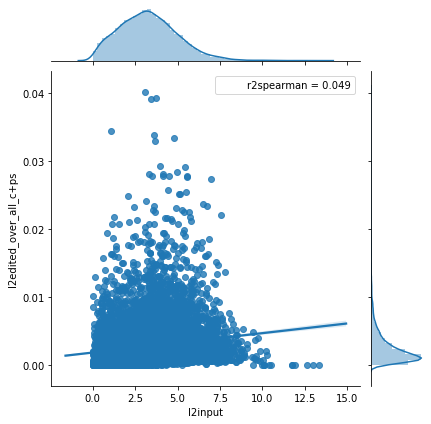

In [33]:
sns.jointplot(
    x='l2input',
    y='l2edited_over_all_c+ps',
    data=read_edit_polysome_escore,
    kind='reg',
    stat_func=r2spearman
)

# Just to check - maybe using rps-0 or Apo-1000 as an input?
- re-do the steps using rps2-0 (rps2_0_file) or ApoControl-0 (apo_1000_file, sample_13_file)